# Painter by Numbers - Overview

In [ ]:
#@title

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if IN_COLAB:
  base_dir = '/content/drive/Shareddrives/datasets/painter-by-numbers'
else:
  base_dir = '/data/painter-by-numbers'

solution_file = f'{base_dir}/meta/solution_painter.csv'
submission_info_file = f'{base_dir}/meta/submission_info.csv'
info_file = f'{base_dir}/meta/all_data_info.csv'
train_info_file = f'{base_dir}/meta/train_info.csv'

labels = ['different-artist', 'same-artist']

strategy = 'mean'

TOTAL_ANSWERS = 21916047
USED_ANSWERS = 1.0

info_features = 'artist_group artist_name style genre source date'.split()

## Setup

In [ ]:
import sys
import json
import warnings

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [ ]:
pd.set_option('display.max_rows', 512)

def as_percentage(df, values='values', reduce_op=np.sum):
    return df.assign(**{values: df[values] / reduce_op(df[values])})

## Dataset

### Reading Solution and Submission Info

In [ ]:
from hashlib import md5

def load_info(all_info_path, train_info_path):
    info = pd.read_csv(all_info_path).rename(columns={'new_filename': 'filename', 'artist': 'artist_name'})
    train_info = (pd.read_csv(train_info_path)
                  .drop(columns='title style genre date'.split())
                  .rename(columns={'artist': 'artist_hash'})
                  .set_index('filename'))

    info = info.merge(train_info, on='filename', how='left')

    # Remove months, fic, circa and other textual
    # info from dates. Them cast them to float.
    info['date'] = (info.date
                    .str.lstrip(r'c\.|(January|February|March|April|May|September|October|November|December)\s')
                    .str.replace('fic', 'nan', regex=False)
                    .str.replace(r'^$', 'nan', regex=True)
                    .astype(float))

    # Clear artist name. 
    info['artist_name'] = info.artist_name.str.strip().astype('str')
    
    # Build artist-hash based on the artist name.
    # Some artist hashes are missing. We will fill them by hashing the artist name.
    codes = info[~info.artist_hash.isna()][['artist_name', 'artist_hash']].drop_duplicates()
    codes = dict(zip(codes.artist_name, codes.artist_hash))

    hashes = info.artist_hash.copy()
    new_hashes = info.artist_name.map(lambda n: codes.get(n, md5(n.encode()).hexdigest()))
    hashes[hashes.isna()] = new_hashes[hashes.isna()]
    info['artist_hash'] = hashes

    return info

info = load_info(info_file, train_info_file)
info.set_index('filename', inplace=True)

info.head()

,artist_name,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,artist_hash
filename,,,,,,,,,,,,
102257.jpg,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,5b39c876740bfc1cfaf544721c43cac3
75232.jpg,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,5b39c876740bfc1cfaf544721c43cac3
32145.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
20304.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
836.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3


In [ ]:
# Fixes some of the artist names that incorrectly
# contain part of the painting name.
fixes = (
    ('Mirror of the Ages', 'Toyohara Chikanobu'),
    ('La Dame de Biarritz', 'Giovanni Boldini'),
    ('Nikolai Evreinov "Pro Scena Suo.."', 'Nikolai Evreinov'),
    ('Messolonghi Lagoon', 'Konstantinos Maleas'),
    ('Modality Series', 'Jock Macdonald'),
    ('Mon Tokyo', 'Kiyoshi Saito'),
    ('Monhegan', 'Robert Henri'),
    ('Moon', 'Nakagawa Soen'),
    ('Moonlight', 'Eugene Boudin'),
    ('Morgat', 'Maxime Maufra'),
    ('Morning', 'Koloman Moser'),
)

for a, b in fixes:
    info.loc[info.artist_name == a, 'artist_name'] = b

In [ ]:
solution, submission = map(pd.read_csv, (solution_file, submission_info_file))
[f.set_index('index', inplace=True) for f in [solution, submission]]
solution = submission.join(solution)
del submission

solution.head()

,image1,image2,sameArtist
index,,,
0,100005.jpg,100004.jpg,0.0
1,100014.jpg,100004.jpg,0.0
2,100014.jpg,100005.jpg,0.0
3,100022.jpg,100004.jpg,0.0
4,100022.jpg,100005.jpg,0.0


## Summary

In [ ]:
info.head()

,artist_name,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,artist_hash
filename,,,,,,,,,,,,
102257.jpg,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,5b39c876740bfc1cfaf544721c43cac3
75232.jpg,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,5b39c876740bfc1cfaf544721c43cac3
32145.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
20304.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
836.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3


### Dates

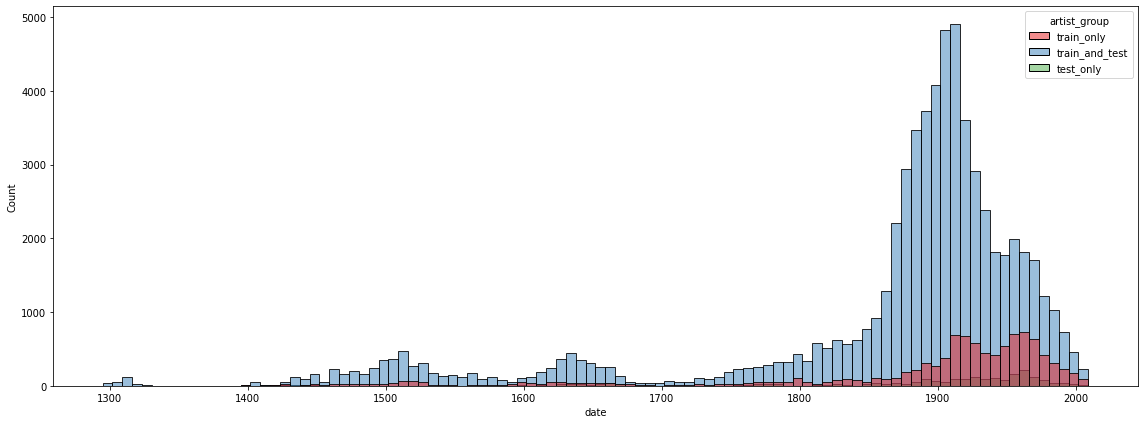

In [ ]:
#@title Creation Date Distributions

extremes = np.percentile(info.date[~info.date.isna()], [0.1, 99.9])
valids = (info.date > extremes[0]) & (info.date < extremes[1])

plt.figure(figsize=(16, 6))
sns.histplot(data=info[valids], x='date', hue='artist_group', bins=100, palette='Set1')
plt.tight_layout();

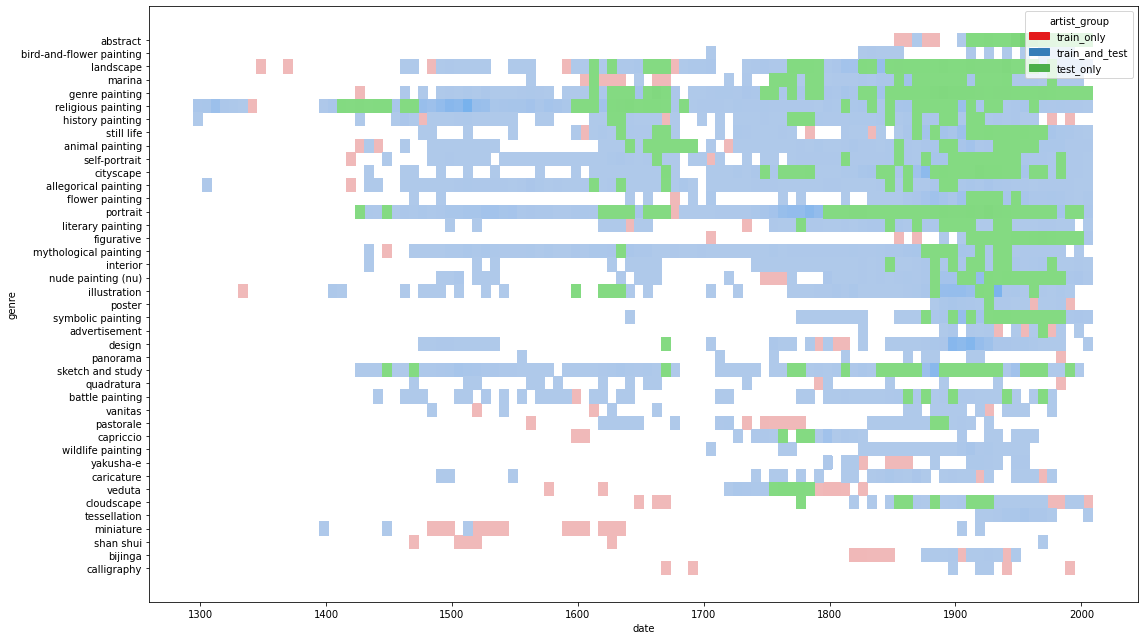

In [ ]:
#@title Creation Date per Genre

p = sns.husl_palette(3)

plt.figure(figsize=(16, 9))
sns.histplot(data=info[valids], y='genre', x='date', hue='artist_group', bins=100, palette='Set1')
plt.tight_layout();

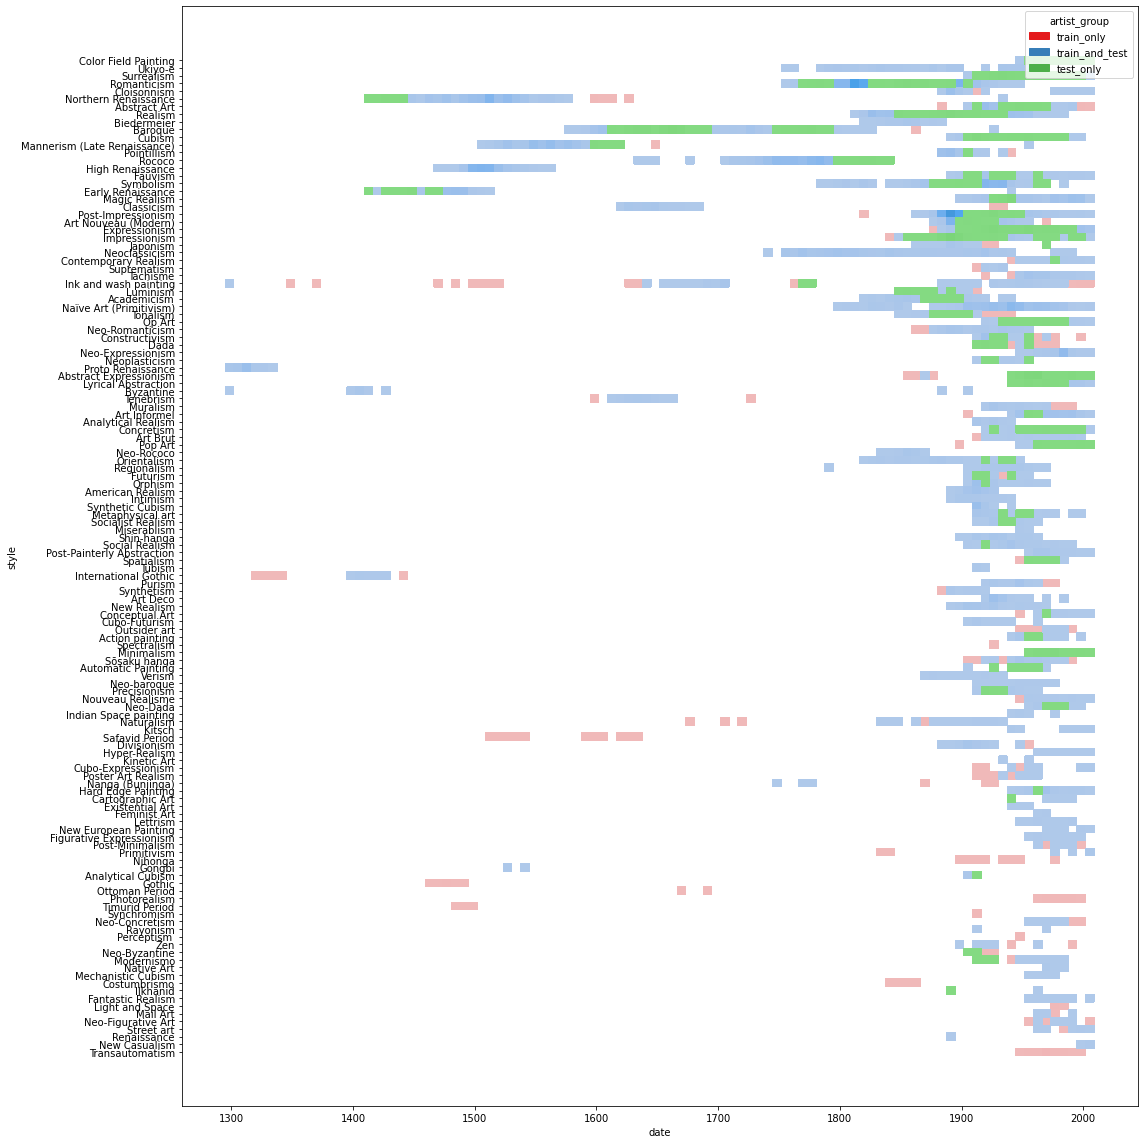

In [ ]:
#@title Creation Date per Style

plt.figure(figsize=(16, 16))
sns.histplot(data=info[valids], y='style', x='date', hue='artist_group', bins=100, palette='Set1')
plt.tight_layout();

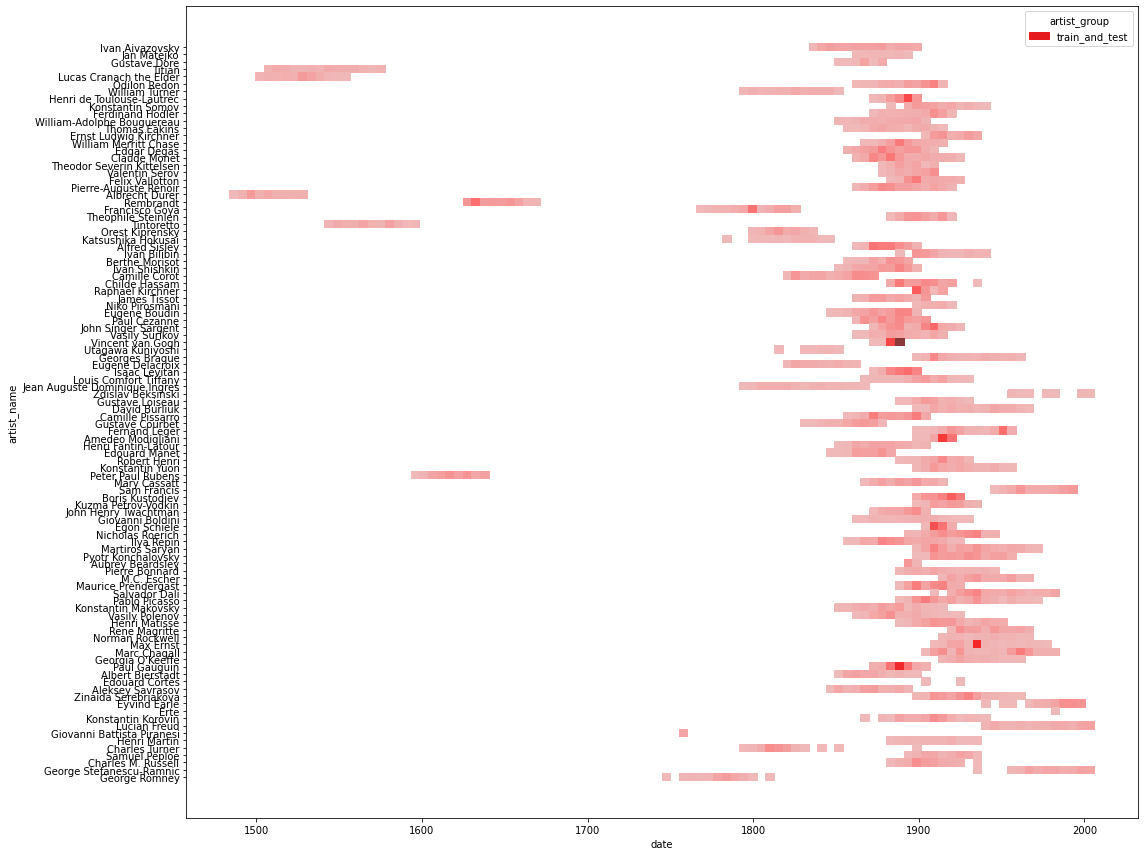

In [ ]:
# #@title Creation Date per Artist

most_frequent_painters = info.groupby('artist_name').agg({'artist_hash': 'count'}).sort_values('artist_hash', ascending=False).head(100)

plt.figure(figsize=(16, 12))
sns.histplot(data=info[valids].merge(most_frequent_painters, on='artist_name'), y='artist_name', x='date', hue='artist_group', bins=100, palette='Set1')
plt.tight_layout();

### Artists

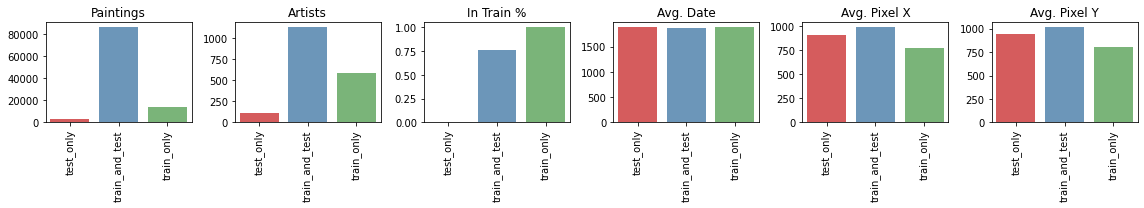

In [ ]:
#@title Stats per Groups

metrics = ('Paintings', 'Artists', 'In Train %', 'Avg. Date', 'Avg. Pixel X', 'Avg. Pixel Y')

stats = info.groupby('artist_group', as_index=False).agg({
    'artist_name': 'count',
    'artist_hash': 'nunique',
    'in_train': 'mean',
    'date': 'mean',
    'pixelsx': 'mean',
    'pixelsy': 'mean',
})

stats.columns = ['Group', *metrics]


plt.figure(figsize=(16, 3))

for ix, metric in enumerate(metrics):
  plt.subplot(1, len(metrics), ix+1)
  sns.barplot(data=stats, x='Group', y=metric, label=metric, palette='Set1', alpha=.8)
  plt.ylabel(None)
  plt.xlabel(None)
  plt.title(metric)
  plt.xticks(rotation=90)

plt.tight_layout();

#### Most Frequent Artists

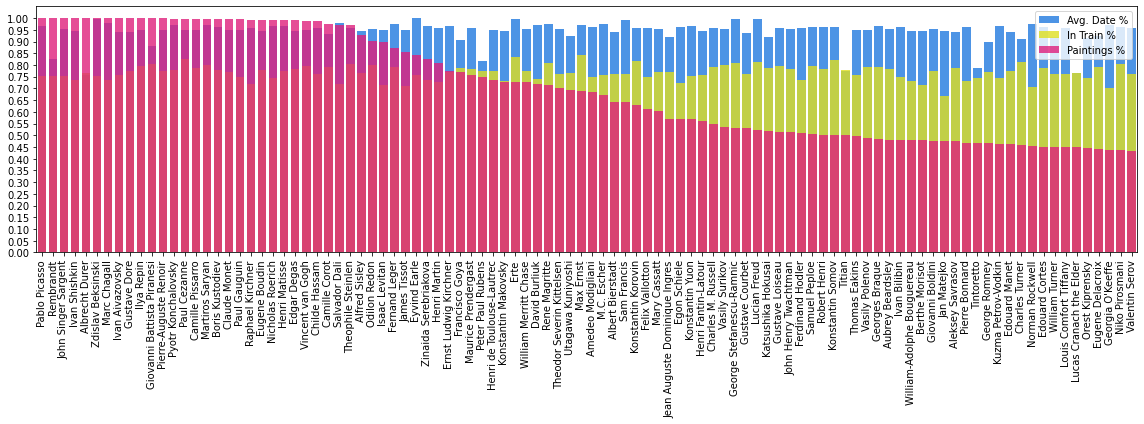

In [ ]:
#@title Paintings, In Train % and Avg. Date %

stats = info.groupby(['artist_name'], as_index=False).agg({
    'artist_hash': 'count',
    'in_train': 'mean',
    'artist_group': 'first',
    'date': 'mean',
    'pixelsx': 'mean',
    'pixelsy': 'mean',
})

stats.columns = ['artist', 'paintings', 'in_train_rate', 'artist_group', 'date_avg', 'pixelsx_avg', 'pixelsy_avg']

stats.sort_values('paintings', ascending=False, inplace=True)

valids = stats.paintings >= 5
stats = stats[valids]


stats_ = stats.head(100)

plt.figure(figsize=(16, 6))

sns.barplot(data=stats_.assign(date_rate=stats_.date_avg / stats_.date_avg.max()),
            x='artist', y='date_rate', label='Avg. Date %', color='#0077ff', alpha=.8)
sns.barplot(data=stats_,
            x='artist', y='in_train_rate', label='In Train %', color='yellow', alpha=.8)
sns.barplot(data=stats_.assign(paintings_rate=stats_.paintings / stats_.paintings.max()),
            x='artist', y='paintings_rate', label='Paintings %', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

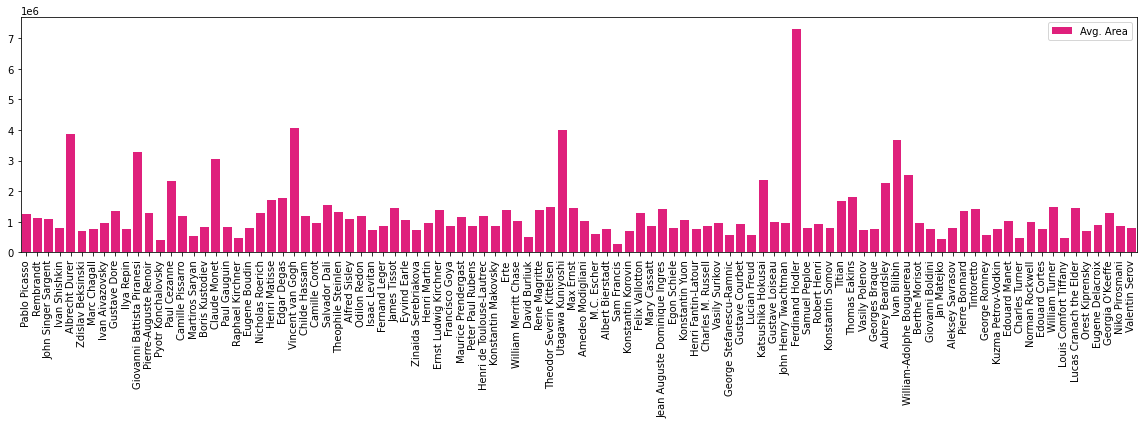

In [ ]:
#@title Avg. Area of Painting Images

plt.figure(figsize=(16, 6))
sns.barplot(data=stats_.assign(area_avg=stats_.pixelsx_avg*stats_.pixelsy_avg), x='artist', y='area_avg', label='Avg. Area', color='#ff007b')
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

In [ ]:
stats_.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
paintings,100.0,353.94,109.64,217.00,248.00,343.00,493.25,500.00
in_train_rate,100.0,0.77,0.03,0.67,0.75,0.77,0.79,0.84
date_avg,100.0,1877.85,89.14,1506.69,1880.36,1895.49,1916.97,1988.46
pixelsx_avg,100.0,1063.77,335.62,534.01,868.82,1012.62,1143.36,2748.65
pixelsy_avg,100.0,1092.32,363.45,531.65,873.24,985.81,1226.75,2659.46


In [ ]:
stats_

,artist,paintings,in_train_rate,artist_group,date_avg,pixelsx_avg,pixelsy_avg
1580,Pablo Picasso,500,0.754000,train_and_test,1920.185263,1035.538000,1226.666000
1716,Rembrandt,500,0.752000,train_and_test,1642.427907,1010.072000,1098.892000
1125,John Singer Sargent,500,0.754000,train_and_test,1898.866667,1015.550000,1078.638000
982,Ivan Shishkin,500,0.734000,train_and_test,1881.084034,939.302000,837.782000
102,Albrecht Durer,500,0.766000,train_and_test,1506.694915,1790.710000,2160.128000
2196,Zdislav Beksinski,500,0.752000,train_and_test,1981.857143,785.126000,873.060000
1353,Marc Chagall,500,0.734000,train_and_test,1944.415800,864.592000,885.404000
973,Ivan Aivazovsky,500,0.756000,train_and_test,1868.147059,1112.756000,857.168000
832,Gustave Dore,500,0.774000,train_and_test,1869.760000,1062.682000,1278.716000
947,Ilya Repin,500,0.794000,train_and_test,1889.384439,828.978000,905.388000


#### Under-represented Artists

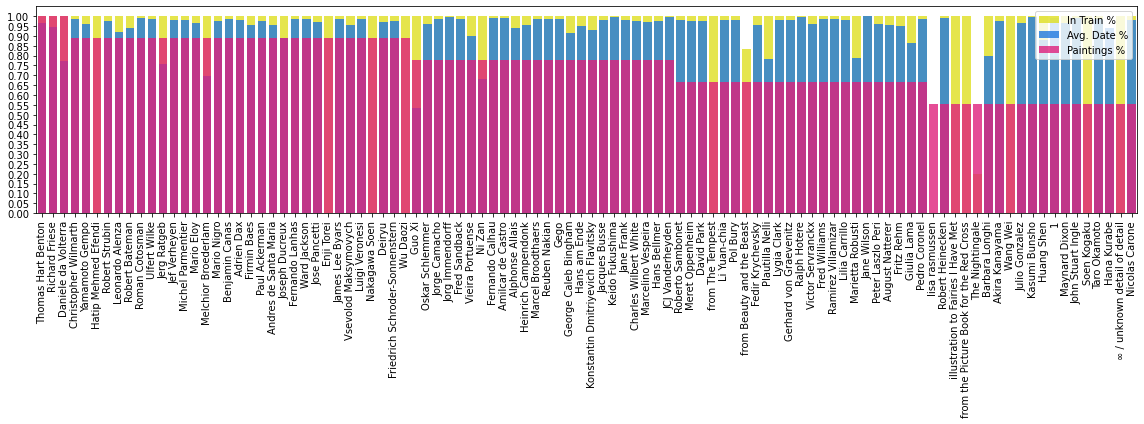

In [ ]:
#@title Paintings, Avg. Date % and In Train %

stats_ = stats.tail(100)

plt.figure(figsize=(16, 6))

sns.barplot(data=stats_, x='artist', y='in_train_rate', label='In Train %', color='yellow', alpha=.8)
sns.barplot(data=stats_.assign(date_rate=stats_.date_avg / stats_.date_avg.max()), x='artist', y='date_rate', label='Avg. Date %', color='#0077ff', alpha=.8)
sns.barplot(data=stats_.assign(paintings_rate=stats_.paintings / stats_.paintings.max()), x='artist', y='paintings_rate', label='Paintings %', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

In [ ]:
stats_.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
paintings,100.0,6.76,1.17,5.0,6.00,7.00,8.00,9.0
in_train_rate,100.0,0.98,0.13,0.0,1.00,1.00,1.00,1.0
date_avg,87.0,1896.66,158.37,1074.0,1914.69,1956.67,1972.06,2003.0
pixelsx_avg,100.0,643.03,208.35,348.6,499.89,600.00,742.81,1353.6
pixelsy_avg,100.0,682.67,249.92,372.6,503.96,606.14,777.32,1629.8


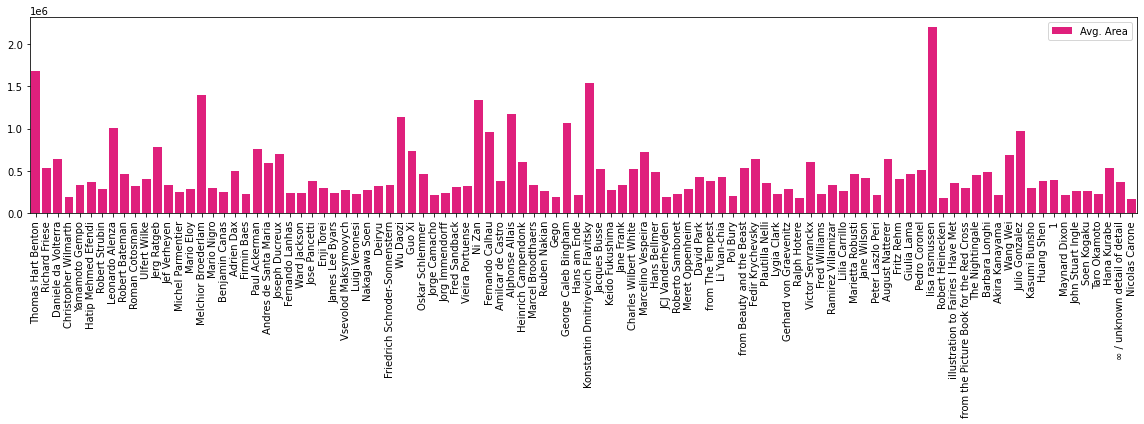

In [ ]:
#@title Under-represented Painters's Painting Image's Avg. Area

plt.figure(figsize=(16, 6))
sns.barplot(data=stats_.assign(area_avg=stats_.pixelsx_avg*stats_.pixelsy_avg), x='artist', y='area_avg', label='Avg. Area', color='#ff007b')
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

### Styles

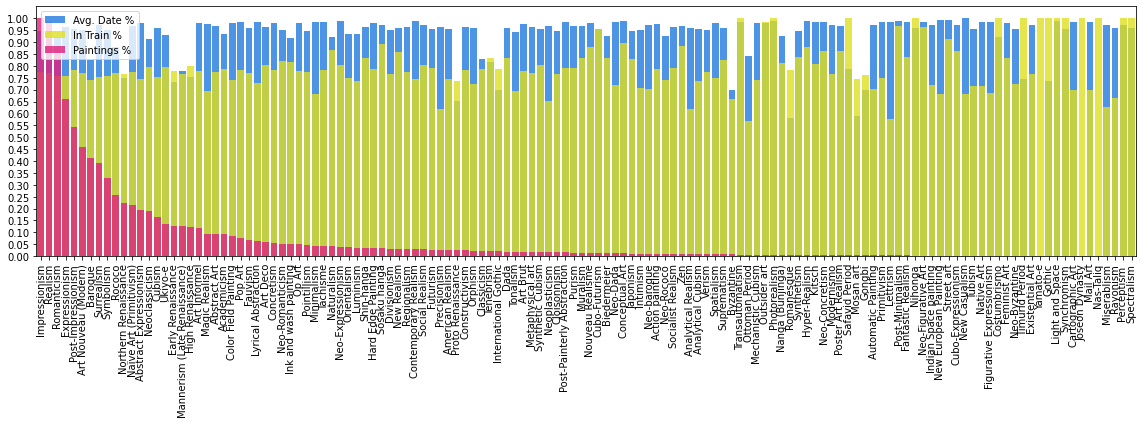

In [ ]:
#@title

stats = info.groupby(['style'], as_index=False).agg({
    'artist_hash': 'count',
    'in_train': 'mean',
    'artist_group': 'first',
    'date': 'mean',
    'pixelsx': 'mean',
    'pixelsy': 'mean',
})

stats.columns = ['style', 'paintings', 'in_train_rate', 'artist_group', 'date_avg', 'pixelsx_avg', 'pixelsy_avg']

stats.sort_values('paintings', ascending=False, inplace=True)

valids = stats.paintings >= 5
stats = stats[valids]

stats_ = stats

plt.figure(figsize=(16, 6))

sns.barplot(data=stats_.assign(date_rate=stats_.date_avg / stats_.date_avg.max()),
            x='style', y='date_rate', label='Avg. Date %', color='#0077ff', alpha=.8)
sns.barplot(data=stats_,
            x='style', y='in_train_rate', label='In Train %', color='yellow', alpha=.8)
sns.barplot(data=stats_.assign(paintings_rate=stats_.paintings / stats_.paintings.max()),
            x='style', y='paintings_rate', label='Paintings %', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

In [ ]:
stats.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
paintings,132.0,774.67,1823.73,5.00,38.75,145.50,470.25,10643.00
in_train_rate,132.0,0.80,0.10,0.57,0.74,0.78,0.83,1.00
date_avg,129.0,1873.33,169.26,1167.80,1895.70,1930.68,1967.45,2005.29
pixelsx_avg,132.0,843.05,324.49,373.30,641.53,794.44,994.90,3308.08
pixelsy_avg,132.0,868.29,269.13,429.77,666.72,838.31,997.26,1954.10


### Genres

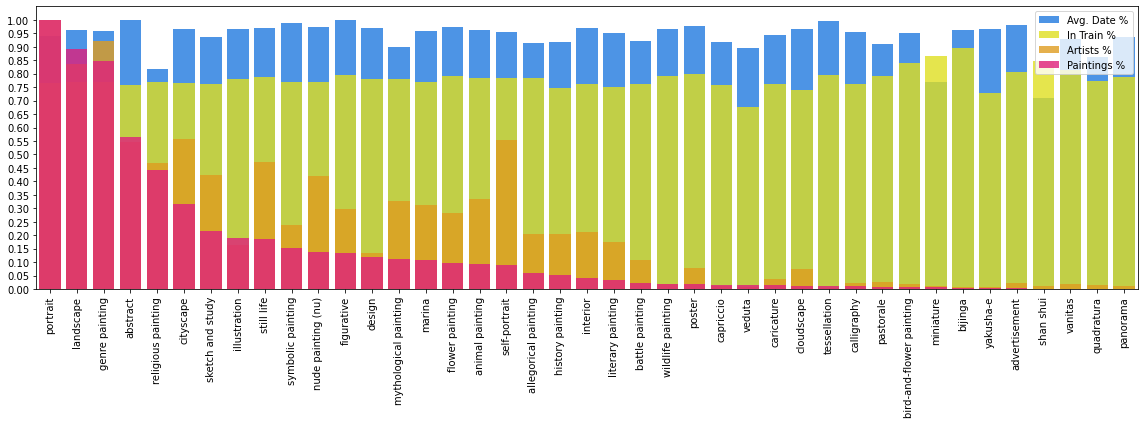

In [ ]:
#@title

stats = info.groupby(['genre'], as_index=False).agg({
    'artist_name': 'count',
    'artist_hash': 'nunique',
    'in_train': 'mean',
    'artist_group': 'first',
    'date': 'mean',
    'pixelsx': 'mean',
    'pixelsy': 'mean',
})

stats.columns = ['genre', 'paintings', 'artists', 'in_train_rate', 'artist_group', 'date_avg', 'pixelsx_avg', 'pixelsy_avg']

stats.sort_values('paintings', ascending=False, inplace=True)

valids = stats.paintings >= 5
stats = stats[valids]

stats_ = stats

plt.figure(figsize=(16, 6))

sns.barplot(data=stats_.assign(date_rate=stats_.date_avg / stats_.date_avg.max()),
            x='genre', y='date_rate', label='Avg. Date %', color='#0077ff', alpha=.8)
sns.barplot(data=stats_,
            x='genre', y='in_train_rate', label='In Train %', color='yellow', alpha=.8)
sns.barplot(data=stats_.assign(artists_rate=stats_.artists / stats_.artists.max()),
            x='genre', y='artists_rate', label='Artists %', color='orange', alpha=.8)
sns.barplot(data=stats_.assign(paintings_rate=stats_.paintings / stats_.paintings.max()),
            x='genre', y='paintings_rate', label='Paintings %', color='#ff007b', alpha=.8)

plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel(None)
plt.legend()
plt.tight_layout();

In [ ]:
stats.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
paintings,41.0,2487.68,4196.34,19.00,160.00,670.00,2290.00,16847.00
artists,41.0,231.39,260.72,5.00,19.00,163.00,331.00,988.00
in_train_rate,41.0,0.78,0.04,0.68,0.76,0.77,0.79,0.89
date_avg,41.0,1841.08,115.18,1390.40,1805.66,1878.10,1899.94,1962.56
pixelsx_avg,41.0,966.25,190.28,620.47,853.19,965.98,1091.81,1577.84
pixelsy_avg,41.0,999.96,159.36,683.71,908.60,1010.34,1112.24,1334.84


## Few-Shot

In [ ]:
#@title

def check_how_many_artists(stats):
  report = []

  for samples in (5, 10, 50, 100):
    report.append((f'Artists with {samples:3d} or less paintings',
                   len(stats[stats.paintings <= samples])))
  
  for samples in (100, 200, 300, 500):
    report.append((f'Artists with {samples:3d} or more paintings',
                   len(stats[stats.paintings >= samples])))
  
  return pd.DataFrame(report, columns=['M', 'Value'])

In [ ]:
artists = (
  info
  .groupby('artist_hash')
  .agg({'artist_name': 'count', 'artist_group': 'first'})
  .rename(columns={'artist_name': 'paintings'})
  .sort_values('paintings')
)

artists[artists.paintings >= 5].sample(5)

,paintings,artist_group
artist_hash,,
8a1a67964c0cbea29fc9801b5c42c553,500,train_and_test
bdb4e548508f23d25558604e7dd073c3,31,train_and_test
2c3565fbb40f040a5756ab50159bcaa1,74,train_and_test
9db9221e9883ca1b7f10e11b76a1c2fa,37,train_only
951e6fd06faf6a38aea8cfcb9d03c2cc,29,train_only


In [ ]:
artists_train = artists[(artists.paintings >= 5) & artists.artist_group.str.contains('train')]
artists_test = artists[(artists.paintings >= 5) & ~artists.artist_group.str.contains('train')]

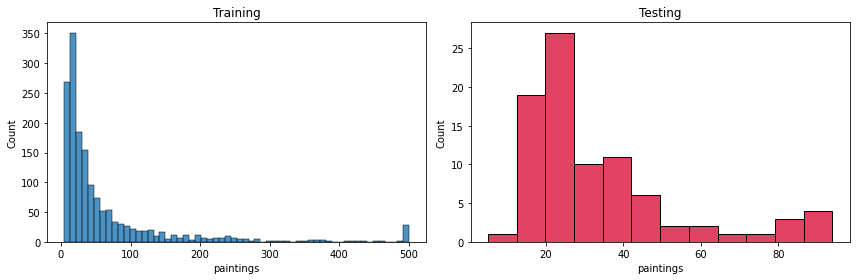

In [ ]:
#@title

plt.figure(figsize=(12, 4))
plt.subplot(121); plt.title('Training'); sns.histplot(artists_train.paintings, label='Train', alpha=0.8)
plt.subplot(122); plt.title('Testing'); sns.histplot(artists_test.paintings, label='Test', color='crimson', alpha=0.8)
plt.tight_layout();

In [ ]:
check_how_many_artists(artists_train)

,M,Value
0,Artists with 5 or less paintings,13
1,Artists with 10 or less paintings,161
2,Artists with 50 or less paintings,1084
3,Artists with 100 or less paintings,1327
4,Artists with 100 or more paintings,259
5,Artists with 200 or more paintings,111
6,Artists with 300 or more paintings,57
7,Artists with 500 or more paintings,18


In [ ]:
check_how_many_artists(artists_test)

,M,Value
0,Artists with 5 or less paintings,1
1,Artists with 10 or less paintings,1
2,Artists with 50 or less paintings,74
3,Artists with 100 or less paintings,87
4,Artists with 100 or more paintings,0
5,Artists with 200 or more paintings,0
6,Artists with 300 or more paintings,0
7,Artists with 500 or more paintings,0
